Tamanho da borda é definido pelo tamanho da máscara
Pixels da borda podem ser replicação do píxel próximo

Filtro de média iria suavizar/borrar, se necessário suavizar mais poderia aumentar o tamanho da máscara
[0, 1,   2]
[1, 128, 3]
[2, 3,   4]

Quando é suavização a soma dos elementos da máscara deve dar 1
1/9 * [1, 1, 1] x 3 = 1

Por isso gaussiano divide 1/16
[1, 2, 1]
[2, 4, 2]
[1, 2, 1]

Filtros estatísticos (mediana e min, max) não possuem máscara, mas sim janelamento: Imagina-se um espaço 3x3, e escolhe a mediana ou o max,min naquele espaço

Shapenning - destacamento das bordas
valores da máscara devem ser zero 0, por isso valores negativos
O resultado da aplicação de shapenning deve ser somado a imagem original

Detecção de borda vem do sharpenning

sobel: ao inve´s de magnitude = np.sqrt(total_horizontal**2 + total_vertical**2)
dava para fazer |total_horizontal| + |total_vertical|

Universidade do Vale do Itajaí<br>
Escola Politécnica<br>
Processamento Digital de Sinais: Imagens

# Exercício Avalitivo de Filtragem Espacial

### Tutoriais da OpenCV

- https://docs.opencv.org/master/d9/df8/tutorial_root.html
- https://www.geeksforgeeks.org/opencv-python-tutorial/

## Conversão de imagem RGB em imagem Grayscale

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


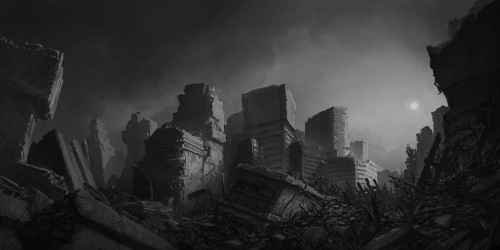

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount('/content/drive')

def Grayscale(path):
  img = cv2.imread(path, 1)
  B, G, R = cv2.split(img)
  img_grayscale_pondered = 0.299*B+0.587*G+0.114*R
  img_grayscale_pondered = np.array(img_grayscale_pondered, dtype=np.uint8)
  return img_grayscale_pondered

def Gauss_create_kernel(sigma=1, size_x=3, size_y=3): # Tem problema aqui
  x, y = np.meshgrid(np.linspace(-1,1,size_x), np.linspace(-1,1,size_y))
  calc = 1/((2*np.pi*(sigma**2)))
  exp = np.exp(-(((x**2) + (y**2))/(2*(sigma**2))))
  return exp*calc

def Convolution(image, mask, isMedian=False, even=False):
  # Funciona para média e mediana
  # É possível convolução com máscara 2x2 se 'even' for true
  N = mask.shape[0] // 2 # Distancia da borda Exemplo: (Kernel 3x3) 3//2=1 ou (Kernal 5x5) 5//2=2
  image_with_border = cv2.copyMakeBorder(image, N, N, N, N, cv2.BORDER_CONSTANT, value=(0, 0, 0)) # A largura da borda é equivalente a distancia do ponto central da máscara com seu limite
  HIGHT, WIDTH = image_with_border.shape
  image_to_return = np.zeros(image.shape)
  for row in range(N, HIGHT-N): # Inicia em N para desconsiderar o inicio da borda e finaliza antes de atingir a borda
    for column in range(N, WIDTH-N):
        limite = 1
        if (even):
          limite = 0
        # Suponha Kernel 3x3, limite será 1 e portanto (row-N:row+N+limite) será 3x3
        # Suponha Kernel 2x2, limite será 0 e portanto (row-N:row+N+limite) será 2x3
        slice = image_with_border[row-N:row+N+limite, column-N:column+N+limite]
        total = 0;
        if (isMedian):
          # Máscara nesse caso apenas demarca a vizinhança
          slice = np.sort(slice.flatten()) # Ordena e torna unidimencional
          total = slice[slice.size // 2] # Total é a mediana
        else:
          total = np.sum(mask * slice).clip(0, 255) # Total é a soma dos produtos, clip garante que o máximo valor seja 255 e o mínimo 0
        image_to_return[row-N, column-N] = total
  return image_to_return

IMG = Grayscale('/content/drive/MyDrive/Colab Notebooks/data/t1.jpg')

cv2_imshow(IMG)


## Filtro Espacial


### Suavização

1. Implemente a sua própria convolução manualmente, em formato de função, utilizando os conceitos vistos em aula
2. Aplique a filtragem de suavização, com as máscaras 3x3, 5x5 e 7x7, com os filtros:
 - média
 - gaussino (escolha uma distribuição adequada, podendo utilizar a função acima ou recuperando a distribuição usada na OpenCV)
 - mediana
4. Relate as observações visíveis nas imagens de saída com os filtros usados, descrevendo o comportamento visual em relação as bordas, ruídos e esmaecimento da imagem com os diferentes kernels

#### Dicas
 - Você pode adicionar ruído nas imagens usando a função random_noise: `from skimage.util import random_noise`. Cuidado com o retorno da função, talvez seja necessário regularizar a mesma novamente para o intervalo de 0 à 255.

Média: Kernel 3x3


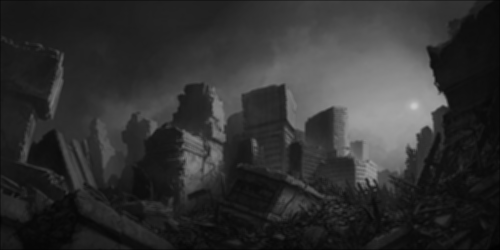

Média: Kernel 5x5


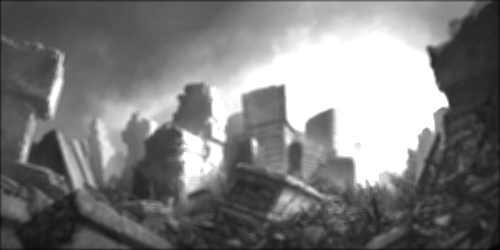

Média: Kernel 7x7


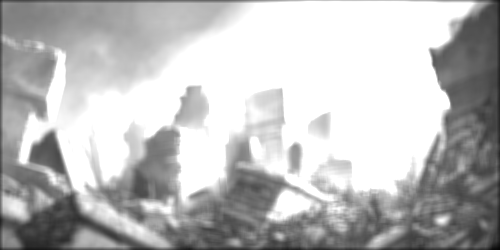

In [ ]:

# Média
MASK_1 = np.ones((3, 3)) * 0.11
MASK_2 = np.ones((5, 5)) * 0.11
MASK_3 = np.ones((7, 7)) * 0.11

print("Média: Kernel 3x3")
cv2_imshow(Convolution(IMG, MASK_1))
#print("Funcao nativa")
#cv2_imshow(cv2.filter2D(IMG, -1, MASK_1))

print("Média: Kernel 5x5")
cv2_imshow(Convolution(IMG, MASK_2))
#print("Funcao nativa")
#cv2_imshow(cv2.filter2D(IMG,-1, MASK_2))

print("Média: Kernel 7x7")
cv2_imshow(Convolution(IMG, MASK_3))
#print("Funcao nativa")
#cv2_imshow(cv2.filter2D(IMG,-1, MASK_3))

Média: Kernel 3x3


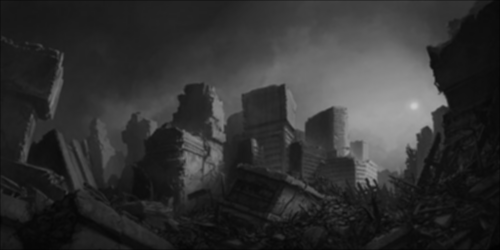

Média: Kernel 5x5


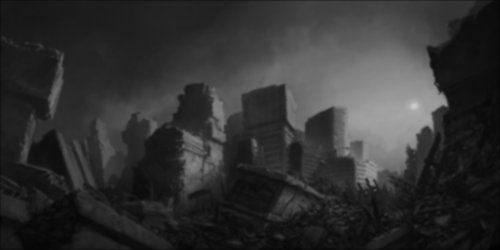

Média: Kernel 7x7


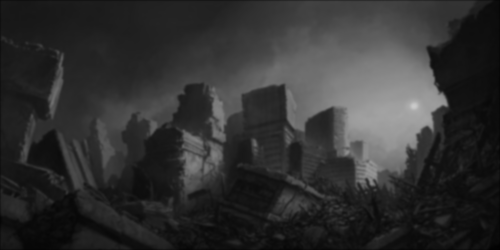

In [ ]:
# Gaussiana
# Usa convolução por média com kernel diferente

def gaussian_mask(n, sigma):
    mask = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(n-1)/2)**2 + (y-(n-1)/2)**2)/(2*sigma**2)),(n, n))
    return mask / np.sum(mask)

MASK_1 = gaussian_mask(3, 1)
MASK_2 = gaussian_mask(5, 1)
MASK_3 = gaussian_mask(7, 1)

print("Média: Kernel 3x3")
cv2_imshow(Convolution(IMG, MASK_1))
#print("Funcao nativa 3x3")
#cv2_imshow(cv2.GaussianBlur(IMG, (3,3), 1))

print("Média: Kernel 5x5")
cv2_imshow(Convolution(IMG, MASK_2))
#print("Funcao nativa 5x5")
#cv2_imshow(cv2.GaussianBlur(IMG, (5,5), 1))

print("Média: Kernel 7x7")
cv2_imshow(Convolution(IMG, MASK_3))
#print("Funcao nativa 7x7")
#cv2_imshow(cv2.GaussianBlur(IMG, (7, 7), 1))

Mediana: Kernel 3x3


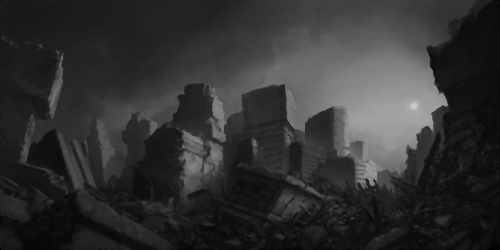

Mediana: Kernel 5x5


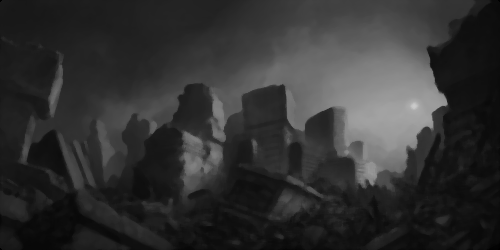

Mediana: Kernel 7x7


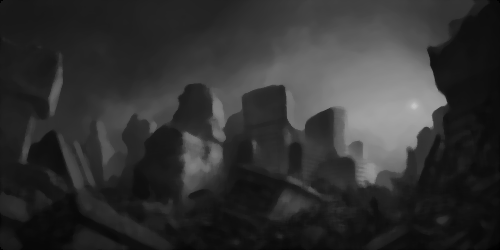

In [ ]:
# Mediana

MASK_1 = np.ones((3, 3))
MASK_2 = np.ones((5, 5))
MASK_3 = np.ones((7, 7))

print("Mediana: Kernel 3x3")
cv2_imshow(Convolution(IMG, MASK_1, True))
#print("Funcao nativa")
#cv2_imshow(cv2.medianBlur(IMG, 3)) # funcao pronta do cv2

print("Mediana: Kernel 5x5")
cv2_imshow(Convolution(IMG, MASK_2, True))
#print("Funcao nativa")
#cv2_imshow(cv2.medianBlur(IMG, 5))

print("Mediana: Kernel 7x7")
cv2_imshow(Convolution(IMG, MASK_3, True))
#print("Funcao nativa")
#cv2_imshow(cv2.medianBlur(IMG, 7))

**Média:**

> O único resultado satisfatório foi obtido com o kernel 3x3. Nota-se nele um bom esmaecimento, com boa eliminação de ruído, e leve distorção nas bordas. Ao aplicar o kernel de 5x5 e 7x7, a distorção de bordas aumenta e a imagem perde as suas características originais: fica mais clara e saturada.




**Gauss:**

> Todos os resultados foram satisfatórios. Com kernel 3x3 nota-se um excelente esmaecimento, com boa eliminação de ruído e distorção de bordas menor que a média. Ao aumentar o tamanho do kernel, a imagem não é distorcida de forma a perder suas características, apenas se torna mais esmaecida. A distorção de bordas se manteve constante, diferentemente da técnica de média.



**Mediana:**
> O esmaecimento aqui é peculiar. Com kernel 3x3 a imagem adquiriu um efeito de cera, muito eficiente na eliminação de ruídos. Ao aumentar o kernel, o esmaecimento também aumenta, de forma semelhante a uma pintura a óleo. Entretanto, ainda conserva melhor as características originais da imagem do que a técnica de média, e não distorce as bordas para nenhum tamanho de kernel.

### Sharpening

4. Implemente os filtros de sharpening, utilizando as diferentes mascarás apresentadas no livro de referência da disciplina:
 - Laplaciano (figura 3.37)
 - Sharpening implementado na figura 3.38
 - Unsharp Masking e Highboost Filtering
 - Implemente os detectores de borda Laplaciano, Roberts e Sobel
 - Utilize a função Canny da OpenCV na mesma imagem usando nos outros detectores




Original


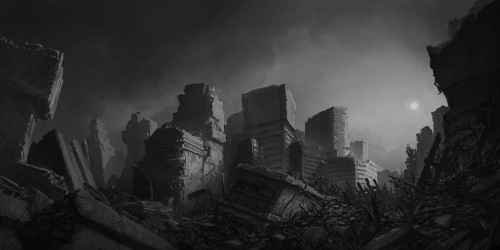


Filtro com mascara: 3x3


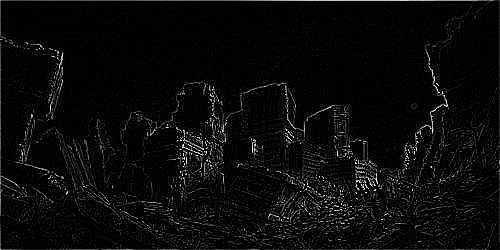

In [ ]:
# LAPLACE
#KERNEL  1  1  1
#        1 -8  1
#        1  1  1

def GenerateKernel(width):
  distance = width // 2
  kernel = -1 * np.ones((width, width))
  kernel[distance, distance] = (width * width) - 1
  return kernel;

LAP_3 = GenerateKernel(3)
#LAP_5 = GenerateKernel(5)
#LAP_7 = GenerateKernel(7)

print("Original")
cv2_imshow(IMG)
print()

filtered = Convolution(IMG, LAP_3)
print("Filtro com mascara: 3x3")
cv2_imshow(filtered)
print()

#print("Filtro com mascara: 5x5")
#cv2_imshow(convolution(IMG, LAP_5))
#print()

#print("Filtro com mascara: 7x7")
#cv2_imshow(convolution(IMG, LAP_7))
#print()

(a) Imagem borrada do polo norte da Lua.


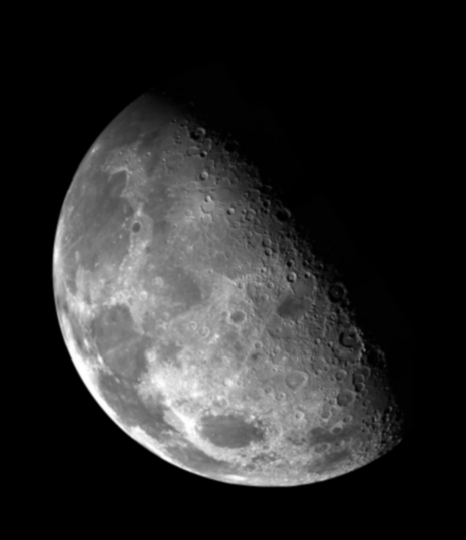

(b) Laplaciano sem ajuste.


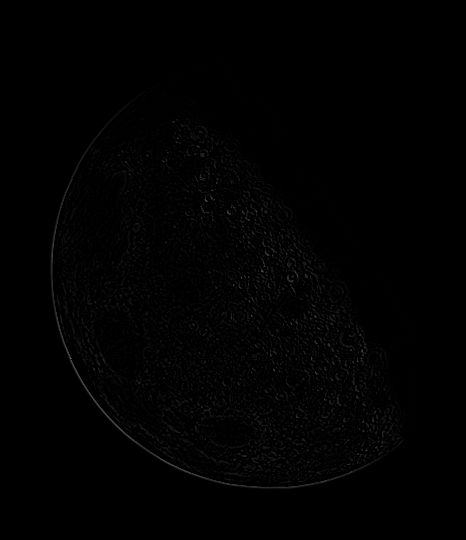

(c) Laplaciano com ajuste.


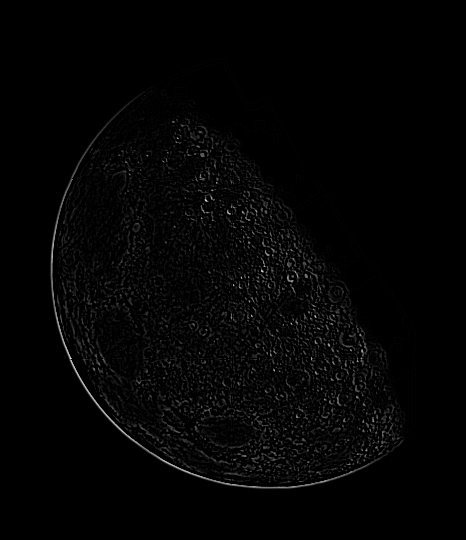

(d) Imagem aguçada utilizando a máscara (a)


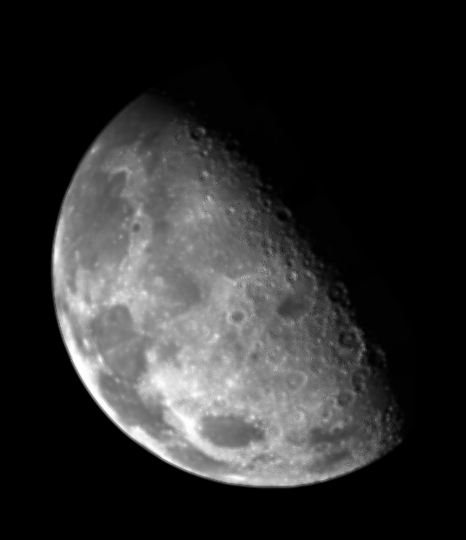

(e) Resultado da utilização da máscara da (b)


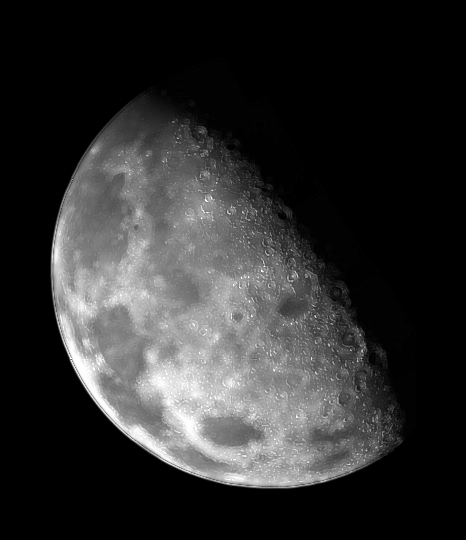

In [ ]:
# Figura 3.38 (a) Imagem borrada do polo norte da Lua. (b) Laplaciano
# sem ajuste. (c) Laplaciano com ajuste. (d) Imagem aguçada utilizando
# a máscara da Figura 3.37(a). (e) Resultado da utilização da máscara da
# Figura 3.37(b). (Imagem original: cortesia da Nasa.)

l_mask_a = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
#l_mask_2 = np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]])
#l_mask_3 = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
l_mask_b = np.array([[1, 1, 1],[1, -8, 1],[1, 1, 1]])

IMG_2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data/Fig0338(a)(blurry_moon).tif", 0)

print("(a) Imagem borrada do polo norte da Lua.")
cv2_imshow(IMG_2)

print("(b) Laplaciano sem ajuste.")
img_lap = Convolution(IMG_2, l_mask_a)
cv2_imshow(img_lap)

print("(c) Laplaciano com ajuste.")
img_lap_scalling = Convolution(IMG_2, l_mask_b)
cv2_imshow(img_lap_scalling)

print("(d) Imagem aguçada utilizando a máscara (a)")
cv2_imshow(np.clip(img_lap + IMG_2, 0, 255))

print("(e) Resultado da utilização da máscara da (b)")
img_3  = Convolution(IMG_2, l_mask_b)
cv2_imshow(img_lap_scalling + IMG_2)



Original


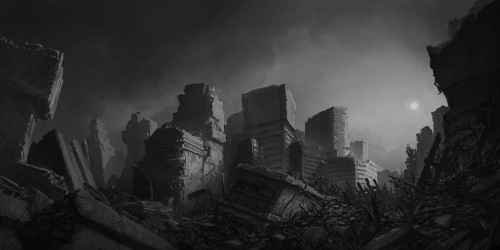

Kernel 3x3


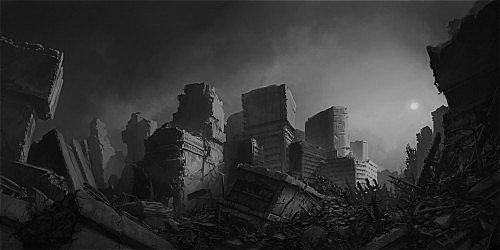

In [ ]:
# Unsharp Masking

MASK_3 = np.ones((3, 3)) * 0.11
#MASK_5 = np.ones((5, 5)) * 0.11
#MASK_7 = np.ones((7, 7)) * 0.11

blur_3 = Convolution(IMG, MASK_3)
#blur_5 = convolution(IMG, MASK_5)
#blur_7 = convolution(IMG, MASK_7)

def UnsharpOrHighBoost(IMG, BLUR, K=1):
  # 1 = Unsharp
  # k > 1 = HighBoost
  mask = K * (IMG - BLUR)
  return mask + IMG

print("Original")
cv2_imshow(IMG)

print("Kernel 3x3")
cv2_imshow(UnsharpOrHighBoost(IMG, blur_3))
print()

#print("Kernel 5x5")
#cv2_imshow(UnsharpOrHighBoost(IMG, blur_5))
#print()

#print("Kernel 7x7")
#cv2_imshow(UnsharpOrHighBoost(IMG, blur_7))
#print()

Original


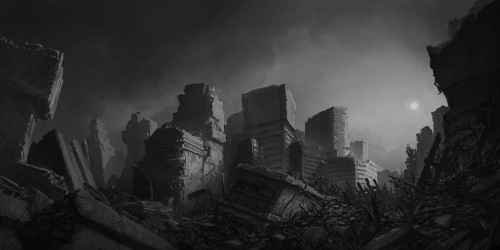

Kernel 3x3


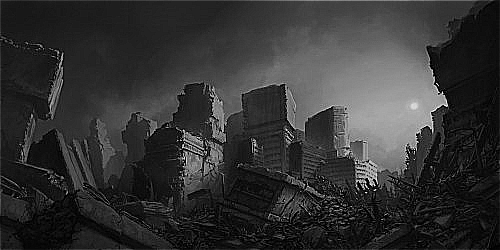

In [ ]:
# Highboost

print("Original")
cv2_imshow(IMG)

print("Kernel 3x3")
cv2_imshow(UnsharpOrHighBoost(IMG, blur_3, 3))
print()

#print("Kernel 5x5")
#cv2_imshow(UnsharpOrHighBoost(IMG, blur_5, 1.5))
#print()

#print("Kernel 7x7")
#cv2_imshow(UnsharpOrHighBoost(IMG, blur_7, 1.5))
#print()

Detectores de Borda

Laplace 1


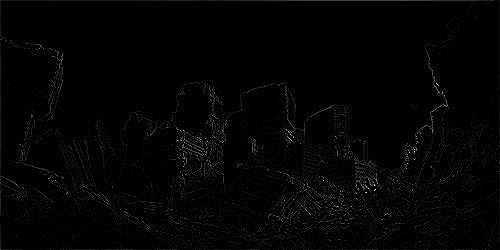

Laplace 2


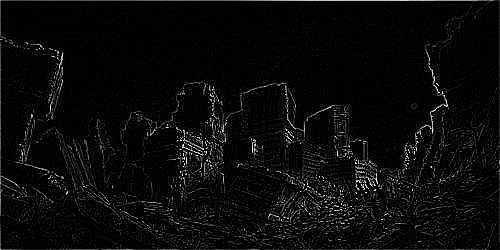

Laplace 1 + 2


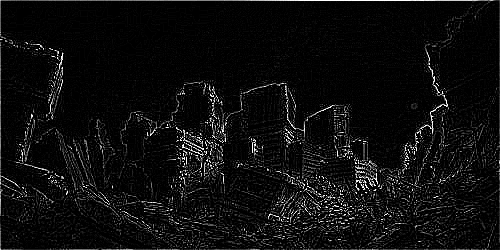

In [ ]:
# Laplace

mask_1 = np.array([[0, -1, 0],
                  [-1,  4, -1],
                  [0, -1, 0]])

mask_2 = np.array([[-1, -1, -1],
                 [-1,  8, -1],
                 [-1, -1, -1]])

print("Laplace 1")
img_1 = Convolution(IMG, mask_1, False)
cv2_imshow(img_1)

print("Laplace 2")
img_2 = Convolution(IMG, mask_2, False)
cv2_imshow(img_2)

print("Laplace 1 + 2")
cv2_imshow(np.clip(img_2 + img_1, 0, 255))


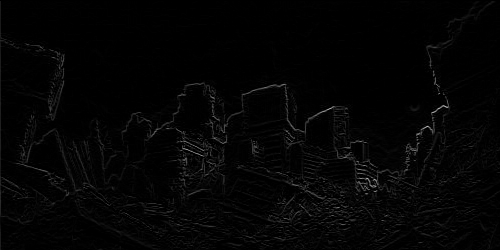

In [ ]:
# Roberts

right = np.array([[1, 0],
                  [0,  -1]])

left = np.array([[0, 1],
                 [-1,  0]])

img_1 = Convolution(IMG, right, False, True)
img_2 = Convolution(IMG, left, False, True)
cv2_imshow(np.clip(img_1 + img_2, 0, 255)) # magnetude ?



Sem magnetude


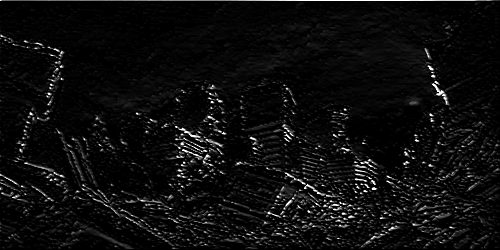

Com magnetude


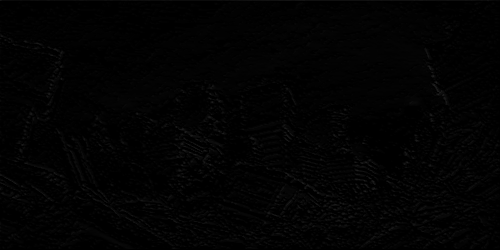

In [ ]:
# Sobel

horizontal = np.array([[-1, -2, -1],
                       [0,  0,  0],
                       [1,  2,  1]])

vertical = np.array([[-1, 0, -1],
                     [-2,  0,  2],
                     [-1,  0,  1]])

img_1 = Convolution(IMG, horizontal)
img_2 = Convolution(img_1, vertical)

print("Sem magnetude")
cv2_imshow(np.clip(img_1 + img_2, 0, 255))

mag = np.sqrt(img_1) + np.sqrt(img_2)
print("Com magnetude")
cv2_imshow(mag)

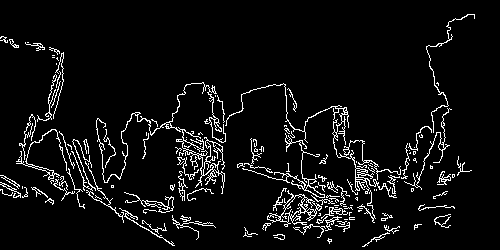

In [ ]:
# Canny

# limiar inferior: menor será descartada como borda
# limiar superior: maior será considerada borda
# Meio: bordas fracas, que podem ser suprimidas ou fortalecidas pelo algortimo automaticamente
bordas_canny = cv2.Canny(IMG, 50, 150)

cv2_imshow(bordas_canny)

6. Você observa uma discrepante melhoria na detecção de bordas pelo Canny em comparação aos outros 3 que justifique a complexidade adicional?
>Sim. A teécnica de Laplace possui uma detecção muito satisfatória para a maioria dos casos, porém, a detecção de Canny é bastante específica e poderosa para o que se propõe. A precisão aqui é admirável

7. Aplique o filtro Sobel pós operação com um filtro de suavização (a sua escolha) e compare com a saída do Canny. Descreva suas observações técnicas sobre o comportamento.

>A. A técnica de Canny permite limitar um escopo de bordas com valores 1 ou 255 que se pretende destacar, enquanto os demais pixels são alterados para 0. Bordas importantes podem ser ignoradas com Canny e a imagem pode ficar difícil de identificar se muitas bordas foram expostas
&nbsp;

>B. A técnica de sobel irá criar bordas onde possível, sem alterar o contraste. A visualização da imagem pode ficar comprometida pela falta de contraste.

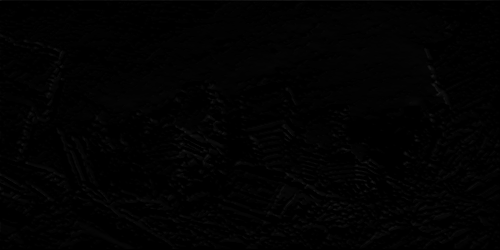

In [ ]:
img_with_blur = cv2.GaussianBlur(IMG, (3,3), 1)

horizontal = np.array([[-1, -2, -1],[0,  0,  0],[1,  2,  1]])
vertical = np.array([[-1, 0, -1],[-2,  0,  2],[-1,  0,  1]])

img_result = Convolution(img_with_blur, horizontal)
img_result2 = Convolution(img_result, vertical)

cv2_imshow(np.clip(np.sqrt(img_result) + np.sqrt(img_result2), 0, 255))
